In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

# 可视化用户画像
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import pandas as pd
from pyspark.ml.clustering import KMeans

In [2]:

# 获取已安装字体的路径
font_path = 'SourceHanSansCN-Regular.otf'

# 创建字体属性对象
font = FontProperties(fname=font_path)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# 创建SparkSession
spark = SparkSession.builder.appName("UserPortrait").getOrCreate()

# 加载用户数据
user_df = spark.read.csv("data/user_data.csv", header=True, inferSchema=True)

# 加载用户行为数据
behavior_df = spark.read.csv("data/user_behavior_data.csv", header=True, inferSchema=True)



23/04/03 19:01:47 WARN Utils: Your hostname, AbeldeMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.248.33.237 instead (on interface en0)
23/04/03 19:01:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/03 19:01:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# 统计用户数据中的记录数量
user_count = user_df.count()

# 统计用户行为数据中的记录数量
behavior_count = behavior_df.count()

# 打印结果
print("用户数据中的记录数量：", user_count)
print("用户行为数据中的记录数量：", behavior_count)


用户数据中的记录数量： 5000
用户行为数据中的记录数量： 100262


/var/folders/dc/s7qx70fx44l4m7cvndrz2jsh0000gn/T/ipykernel_7616/1045465211.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = user_df_pd.corr()


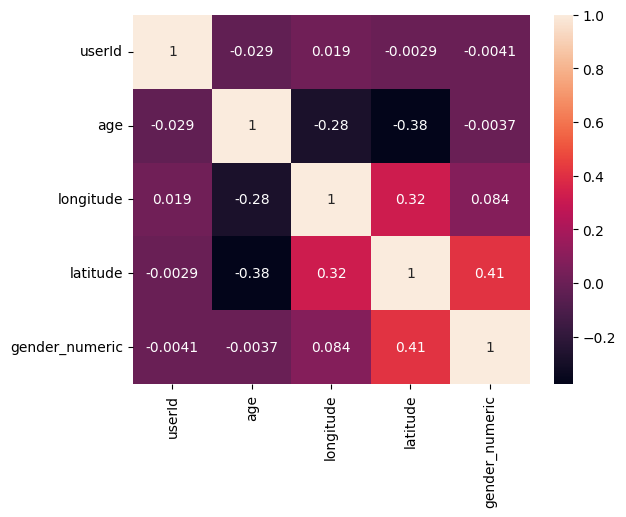

In [5]:
# 计算用户数据中各特征之间的相关系数
# Convert the Spark DataFrame to a Pandas DataFrame
user_df_pd = user_df.toPandas()

# 将性别从分类变量转换为数值变量
user_df_pd['gender_numeric'] = user_df_pd['gender'].map({'Male': 0, 'Female': 1})

# 重新计算相关性矩阵
corr_matrix = user_df_pd.corr()

# 可视化相关性矩阵
sns.heatmap(corr_matrix, annot=True)
plt.show()





# 热力图的商务分析
'''
矩阵中的每个单元格表示两个变量之间的相关系数，范围从 -1（完全负相关）到 1（完全正相关）。如果值接近零，则表示两个变量之间没有显著相关性。

在电商平台的场景中，相关性矩阵可以帮助我们了解用户数据中不同特征之间的关联程度。通过观察相关性矩阵的热力图，
我们可以发现哪些特征之间存在较强的关联，从而更好地理解用户行为和属性。
这可以会为电商平台提供有价值的见解，以优化用户体验、制定更有效的市场策略等
'''

In [25]:
# 训练ALS模型，用于商品推荐
# 协同过滤算法
als = ALS(rank=10, maxIter=15, regParam=0.01, userCol="userId", itemCol="itemId", ratingCol="rating")
model = als.fit(behavior_df)

# 针对每个用户生成推荐列表
user_recs = model.recommendForAllUsers(10)

print('#'*20)


####################


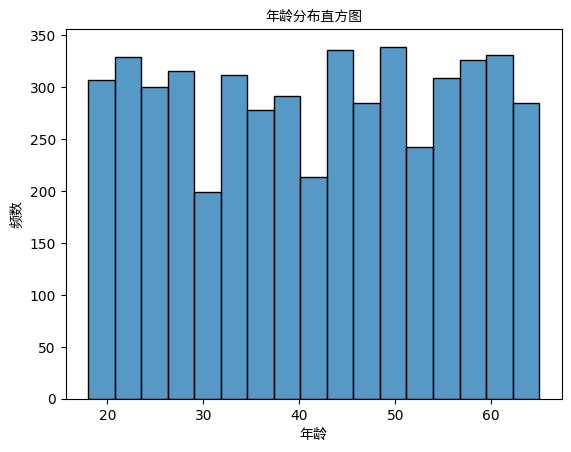

In [26]:
# 将用户画像和推荐结果连接起来
user_recs_with_profile = user_recs.join(user_df, on="userId", how="left")




# 将 PySpark DataFrame 转换为 Pandas DataFrame
user_df_pd = user_df.toPandas()

# 绘制用户年龄分布图
sns.histplot(data=user_df_pd, x="age")


# 绘制用户地理位置云图
# 绘制散点图

plt.xlabel('年龄', fontproperties=font)
plt.ylabel('频数', fontproperties=font)
plt.title('年龄分布直方图', fontproperties=font)
plt.show()





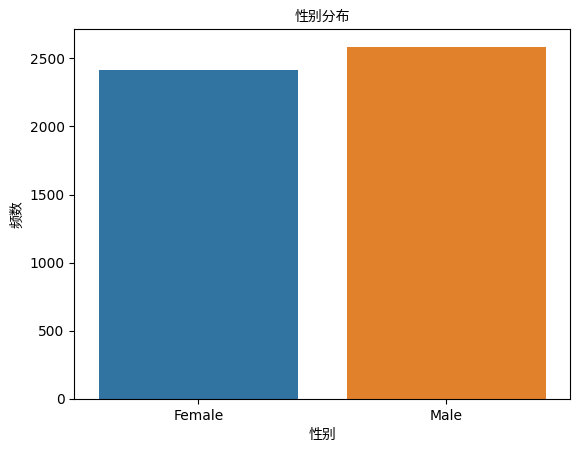

In [27]:
sns.countplot(data=user_df_pd, x="gender")
plt.xlabel('性别', fontproperties=font)
plt.ylabel('频数', fontproperties=font)
plt.title('性别分布', fontproperties=font)
plt.show()


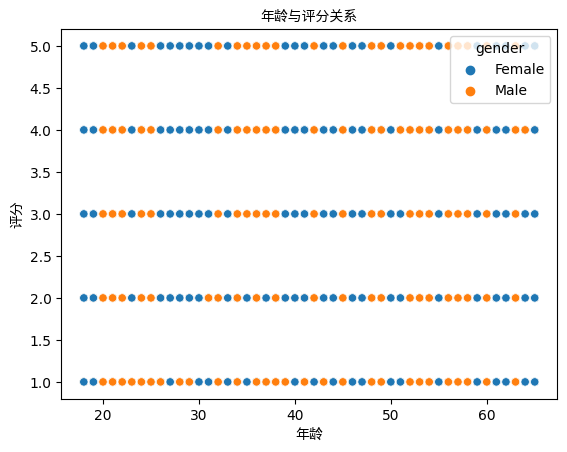

In [28]:
# 用户行为数据转换为 Pandas DataFrame
behavior_df_pd = behavior_df.toPandas()

# 合并用户数据和行为数据
user_behavior_df_pd = pd.merge(user_df_pd, behavior_df_pd, on="userId")

# 绘制年龄与评分的关系
sns.scatterplot(data=user_behavior_df_pd, x="age", y="rating", hue="gender")
plt.xlabel('年龄', fontproperties=font)
plt.ylabel('评分', fontproperties=font)
plt.title('年龄与评分关系', fontproperties=font)
plt.show()

# 年龄与评分关系的分析
'''
展示了电商平台上用户的年龄与他们对商品的评分之间的关系。
在图中，x轴表示用户的年龄，y轴表示用户给商品的评分。数据点根据用户性别着色，
使得我们可以观察到不同性别用户在年龄与评分关系上的差异。

通过这个图表，可以帮助我们了解不同年龄和性别的用户在对商品评价方面的行为。

可以观察到某个年龄段的用户是否对商品评分更高或更低，

或者某个性别的用户在某个年龄段是否倾向于给予更高或更低的评分。
这些可以帮助电商平台了解其目标用户群体，
并根据这些发现调整推荐策略
'''


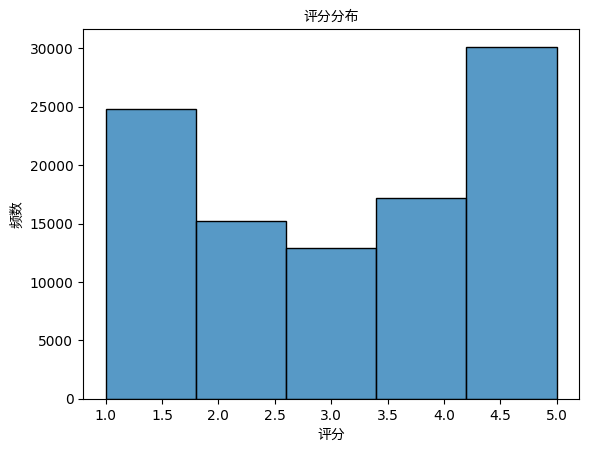

In [29]:
sns.histplot(data=behavior_df_pd, x="rating", bins=5)
plt.xlabel('评分', fontproperties=font)
plt.ylabel('频数', fontproperties=font)
plt.title('评分分布', fontproperties=font)
plt.show()

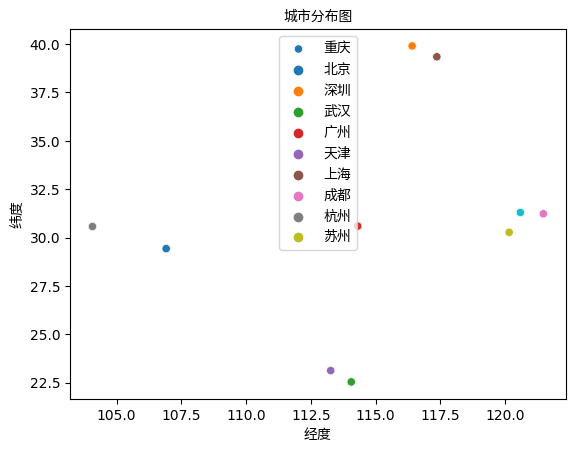

In [30]:
# 绘制用户地理位置云图
sns.scatterplot(data=user_df_pd, x="longitude", y="latitude", hue="city")

# 设置图例字体
current_legend = plt.legend()
plt.legend(title=current_legend.get_title().get_text(), labels=[t.get_text() for t in current_legend.texts], 
           loc=current_legend._loc, prop=font)

# 设置坐标轴标签和标题
plt.xlabel('经度', fontproperties=font)
plt.ylabel('纬度', fontproperties=font)
plt.title('城市分布图', fontproperties=font)

plt.show()


In [31]:

# 生成特征列和标签列
feature_cols = ["age", "longitude", "latitude"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
user_recs_with_profile = assembler.transform(user_recs_with_profile)
user_recs_with_profile = user_recs_with_profile.withColumn("label", 
                                            user_recs_with_profile["gender"].isin(["Male"]).cast("double"))

In [40]:
# 生成特征列和标签列
feature_cols = ["age", "longitude", "latitude"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
user_df = assembler.transform(user_df)
user_df = user_df.withColumn("label", user_df["gender"].isin(["Male"]).cast("double"))

# 划分训练集和测试集
train, test = user_df.randomSplit([0.7, 0.3], seed=1)
# 计算用户标签，使用逻辑回归算法
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=0.1, elasticNetParam=0.5)
lr_model = lr.fit(user_recs_with_profile)

# 使用用户画像和推荐结果生成新用户的标签
new_user_df = pd.DataFrame({"userId": [80], "age": [25], "gender": ["Male"],
                            "city": ["上海"], "longitude": [121.4737], "latitude": [31.2304]})
new_user_df = spark.createDataFrame(new_user_df)

new_user_recs = model.recommendForUserSubset(new_user_df, 10)
new_user_recs_with_profile = new_user_recs.join(new_user_df, on="userId", how="left")
new_user_recs_with_profile = assembler.transform(new_user_recs_with_profile)
new_user_recs_with_profile = new_user_recs_with_profile.withColumn("label", 
                                            new_user_recs_with_profile["gender"].isin(["Male"]).cast("double"))

new_user_labels = lr_model.transform(new_user_recs_with_profile)

/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [33]:
# 显示用户
print("用户：")
user_df.show()




用户：
+------+---+------+----+---------+--------+
|userId|age|gender|city|longitude|latitude|
+------+---+------+----+---------+--------+
|     0| 45|Female|重庆| 106.9123| 29.4316|
|     1| 22|  Male|北京| 116.4074| 39.9042|
|     2| 52|  Male|深圳| 114.0579| 22.5431|
|     3| 41|Female|武汉| 114.3054| 30.5931|
|     4| 33|  Male|深圳| 114.0579| 22.5431|
|     5| 47|  Male|深圳| 114.0579| 22.5431|
|     6| 65|  Male|广州| 113.2644| 23.1291|
|     7| 65|  Male|天津| 117.3616| 39.3434|
|     8| 59|  Male|深圳| 114.0579| 22.5431|
|     9| 23|  Male|上海| 121.4737| 31.2304|
|    10| 42|Female|天津| 117.3616| 39.3434|
|    11| 43|  Male|深圳| 114.0579| 22.5431|
|    12| 58|Female|武汉| 114.3054| 30.5931|
|    13| 63|Female|深圳| 114.0579| 22.5431|
|    14| 53|  Male|深圳| 114.0579| 22.5431|
|    15| 20|  Male|成都| 104.0665| 30.5728|
|    16| 47|  Male|深圳| 114.0579| 22.5431|
|    17| 29|Female|北京| 116.4074| 39.9042|
|    18| 27|  Male|北京| 116.4074| 39.9042|
|    19| 56|  Male|广州| 113.2644| 23.1291|
+------+---+------+----+

In [34]:
# 显示推荐结果
print("推荐结果：")
print('user_recs中的recommendations列包含了为每个用户推荐的商品ID及其对应的预测评分')
user_recs_with_profile.show()



推荐结果：
user_recs中的recommendations列包含了为每个用户推荐的商品ID及其对应的预测评分


+------+--------------------+---+------+----+---------+--------+--------------------+-----+
|userId|     recommendations|age|gender|city|longitude|latitude|            features|label|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+
|    26|[{35, 6.5488663},...| 42|Female|广州| 113.2644| 23.1291|[42.0,113.2644,23...|  0.0|
|    27|[{56, 3.2143524},...| 46|Female|上海| 121.4737| 31.2304|[46.0,121.4737,31...|  0.0|
|    28|[{9, 4.7363496}, ...| 56|  Male|深圳| 114.0579| 22.5431|[56.0,114.0579,22...|  1.0|
|    31|[{15, 5.7710857},...| 27|Female|上海| 121.4737| 31.2304|[27.0,121.4737,31...|  0.0|
|    34|[{45, 3.0625603},...| 56|  Male|深圳| 114.0579| 22.5431|[56.0,114.0579,22...|  1.0|
|    53|[{8, 5.854198}, {...| 27|  Male|北京| 116.4074| 39.9042|[27.0,116.4074,39...|  1.0|
|    65|[{12, 7.987756}, ...| 57|Female|北京| 116.4074| 39.9042|[57.0,116.4074,39...|  0.0|
|    76|[{87, 6.0507383},...| 41|  Male|深圳| 114.0579| 22.5431|[41.0,114.0579,22...|  1.0|
|   

In [35]:
# 显示标签结果
print("标签结果：")
new_user_labels.show()

标签结果：
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+--------------------+----------+
|userId|     recommendations|age|gender|city|longitude|latitude|            features|label|       rawPrediction|         probability|prediction|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+--------------------+----------+
|    80|[{19, 4.723695}, ...| 25|  Male|上海| 121.4737| 31.2304|[25.0,121.4737,31...|  1.0|[0.12481130494883...|[0.53116238312807...|       0.0|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+--------------------+--------------------+----------+



In [43]:
# 导入项目数据 ，我们预设的电商不同房间和类别

item_data = [("75", "Room75", " Ecommerce_categoryA(娱乐)"), 
             ("76", "Room76", " Ecommerce_categoryB（学习）"), 
             ("77", "Room77", " Ecommerce_categoryC（在线虚拟产品）"),
             ("78", "Room78", " Ecommerce_categoryD（运动）"),

             ]

item_df = spark.createDataFrame(item_data, schema=["itemId", "itemName", "itemCategory"])

# 将推荐结果与项目数据关联
from pyspark.sql.functions import explode

# 展开recommendations列，使每行只包含一个推荐项目
user_recs_exploded = user_recs_with_profile.select("userId", explode("recommendations").alias("recommendation"))

# 提取项目ID和评分
user_recs_exploded = user_recs_exploded.select("userId", "recommendation.itemId", "recommendation.rating")

# 将推荐结果与项目数据关联
user_recs_with_item_info = user_recs_exploded.join(item_df, on="itemId", how="left")


user_recs_with_item_info_pd = user_recs_with_item_info.toPandas()
user_recs_with_item_info_pd.to_json('user_recommendations.json', orient='records', lines=True)


# 显示带有项目详细信息的推荐结果
user_recs_with_item_info.show()


+------+------+---------+--------+------------+
|itemId|userId|   rating|itemName|itemCategory|
+------+------+---------+--------+------------+
|     9|    28|4.7363496|    null|        null|
|    27|    28|4.4880996|    null|        null|
|    82|    28| 4.388513|    null|        null|
|    93|    28|4.1226044|    null|        null|
|    83|    28|  4.08145|    null|        null|
|    81|    28|4.0460744|    null|        null|
|    80|    28| 4.009477|    null|        null|
|    57|    28|3.9963934|    null|        null|
|    99|    28|3.9673405|    null|        null|
|    84|    28| 3.900389|    null|        null|
|    15|    31|5.7710857|    null|        null|
|    51|    31| 5.432708|    null|        null|
|    55|    31|5.4078197|    null|        null|
|    21|    31|5.3930197|    null|        null|
|    32|    31|5.3731866|    null|        null|
|    91|    31| 5.311024|    null|        null|
|    11|    31|5.2638845|    null|        null|
|    97|    31| 5.243904|    null|      

# part2
# 使用KMeans算法对用户进行聚
# 使用KMeans算法对用户进行聚类AN

用户画像：
+------+---+------+----+---------+--------+
|userId|age|gender|city|longitude|latitude|
+------+---+------+----+---------+--------+
|     0| 45|Female|重庆| 106.9123| 29.4316|
|     1| 22|  Male|北京| 116.4074| 39.9042|
|     2| 52|  Male|深圳| 114.0579| 22.5431|
|     3| 41|Female|武汉| 114.3054| 30.5931|
|     4| 33|  Male|深圳| 114.0579| 22.5431|
|     5| 47|  Male|深圳| 114.0579| 22.5431|
|     6| 65|  Male|广州| 113.2644| 23.1291|
|     7| 65|  Male|天津| 117.3616| 39.3434|
|     8| 59|  Male|深圳| 114.0579| 22.5431|
|     9| 23|  Male|上海| 121.4737| 31.2304|
|    10| 42|Female|天津| 117.3616| 39.3434|
|    11| 43|  Male|深圳| 114.0579| 22.5431|
|    12| 58|Female|武汉| 114.3054| 30.5931|
|    13| 63|Female|深圳| 114.0579| 22.5431|
|    14| 53|  Male|深圳| 114.0579| 22.5431|
|    15| 20|  Male|成都| 104.0665| 30.5728|
|    16| 47|  Male|深圳| 114.0579| 22.5431|
|    17| 29|Female|北京| 116.4074| 39.9042|
|    18| 27|  Male|北京| 116.4074| 39.9042|
|    19| 56|  Male|广州| 113.2644| 23.1291|
+------+---+------+---

+------+--------------------+---+------+----+---------+--------+--------------------+-----+-------+
|userId|     recommendations|age|gender|city|longitude|latitude|            features|label|cluster|
+------+--------------------+---+------+----+---------+--------+--------------------+-----+-------+
|    28|[{9, 4.7363496}, ...| 56|  Male|深圳| 114.0579| 22.5431|[56.0,114.0579,22...|  1.0|      2|
|    31|[{15, 5.7710857},...| 27|Female|上海| 121.4737| 31.2304|[27.0,121.4737,31...|  0.0|      1|
|    34|[{45, 3.0625603},...| 56|  Male|深圳| 114.0579| 22.5431|[56.0,114.0579,22...|  1.0|      2|
|    53|[{8, 5.854198}, {...| 27|  Male|北京| 116.4074| 39.9042|[27.0,116.4074,39...|  1.0|      1|
|    65|[{12, 7.987756}, ...| 57|Female|北京| 116.4074| 39.9042|[57.0,116.4074,39...|  0.0|      2|
|    76|[{87, 6.0507383},...| 41|  Male|深圳| 114.0579| 22.5431|[41.0,114.0579,22...|  1.0|      0|
|    78|[{40, 6.1601}, {1...| 18|Female|北京| 116.4074| 39.9042|[18.0,116.4074,39...|  0.0|      1|
|    81|[{80, 

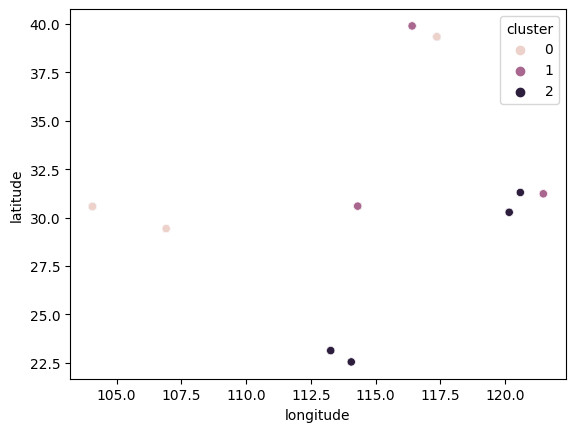

In [37]:
kmeans = KMeans(k=3, seed=1)
kmeans_model = kmeans.fit(user_recs_with_profile.select("features"))

# 添加聚类标签到用户画像数据中
user_clusters = kmeans_model.transform(user_recs_with_profile).select("userId", "prediction").withColumnRenamed("prediction", "cluster")

# 将聚类标签连接到推荐结果数据中
user_recs_with_profile = user_recs_with_profile.join(user_clusters, on="userId", how="left")

# 显示用户画像，包含聚类标签
print("用户画像：")
user_df.show()

# 显示推荐结果，包含聚类标签
print("推荐结果：")
user_recs_with_profile.show()

# 使用用户画像和推荐结果生成新用户的标签
new_user_clusters = kmeans_model.transform(new_user_recs_with_profile.select("features")).select("prediction").withColumnRenamed("prediction", "cluster")
new_user_recs_with_profile = new_user_recs_with_profile.join(new_user_clusters, how="left")

new_user_labels = lr_model.transform(new_user_recs_with_profile)

# 显示标签结果
print("标签结果：")
new_user_labels.show()

# 绘制用户画像分布图，按聚类标签分别显示
sns.scatterplot(data=user_recs_with_profile.toPandas(), x="longitude", y="latitude", hue="cluster")
plt.show()

# part3
# XGBoost分类器


GBT AUC: 0.82
Test Accuracy: 75.54%


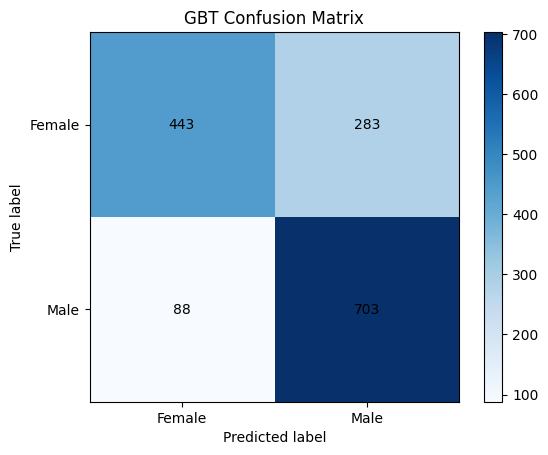

Jaccard Similarity: 65.46%


In [41]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(maxIter=10, featuresCol="features", labelCol="label")
gbt_model = gbt.fit(train)

# 在测试集上评估模型性能
evaluator = BinaryClassificationEvaluator(labelCol="label")
gbt_predictions = gbt_model.transform(test)
gbt_auc = evaluator.evaluate(gbt_predictions)

print("GBT AUC: {:.2f}".format(gbt_auc))


from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

# 计算预测精度
test_accuracy = gbt_predictions.filter(gbt_predictions.label == gbt_predictions.prediction).count() / float(test.count())
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# 获取混淆矩阵
test_prediction_labels = gbt_predictions.select("label", "prediction").rdd.map(lambda x: tuple(x)).toDF(["label", "prediction"])
test_prediction_np = test_prediction_labels.toPandas().to_numpy()
cm = confusion_matrix(test_prediction_np[:, 0], test_prediction_np[:, 1])

# 计算Jaccard相似度
jaccard_similarity = jaccard_score(test_prediction_np[:, 0], test_prediction_np[:, 1])

# 可视化混淆矩阵
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("GBT Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Female", "Male"])
plt.yticks([0, 1], ["Female", "Male"])
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, format(cm[i, j], "d"), ha="center", va="center")
plt.show()

# 输出Jaccard相似度
print("Jaccard Similarity: {:.2f}%".format(jaccard_similarity * 100))



# GBT Confusion Matrix的分析
'''

我们是想评估基于GBT（梯度提升树）分类器在预测用户性别（男性或女性）时的性能。

电商平台上，我们使用用户的年龄、地理位置等特征来预测用户的性别。

通过计算了Jaccard相似度，它是一种用于比较预测标签与真实标签之间相似度的指标。这个值越接近满分，预测性能就越好。

可视化混淆矩阵：这部分代码将混淆矩阵以图形的形式展示出来。混淆矩阵是一个二维矩阵，用于描述分类器在预测结果中的表现。

横轴表示预测标签（预测性别），纵轴表示实际标签（真实性别）。矩阵的每个单元格表示预测结果与实际结果的组合数量。

混淆矩阵的对角线表示正确的预测结果，其它元素表示错误的预测结果。

这个值越高，表示GBT分类器在预测用户性别方面表现越好。计算Jaccard相似度和绘制混淆矩阵，

帮助我们了解GBT分类器在预测电商平台用户性别方面的表现。

这有助于我们了解分类器的性能和准确性，从而对其进行优化。

'''

In [42]:
# 假设您有一个包含新用户画像信息的Pandas DataFrame（new_user_profile_df）
new_user_profile_df = pd.DataFrame({"userId": [5001], "age": [28], "gender": ["Female"],
                                    "longitude": [116.4074], "latitude": [39.9042]})

# 将Pandas DataFrame转换为Spark DataFrame
new_user_profile_spark_df = spark.createDataFrame(new_user_profile_df)

# 使用VectorAssembler将新用户的特征列组合为一个特征向量
new_user_assembled = assembler.transform(new_user_profile_spark_df)

# 使用训练好的GBT模型对新用户进行预测
new_user_predictions = gbt_model.transform(new_user_assembled)

# 显示新用户的预测结果
new_user_predictions.show()


+------+---+------+---------+--------+--------------------+--------------------+--------------------+----------+
|userId|age|gender|longitude|latitude|            features|       rawPrediction|         probability|prediction|
+------+---+------+---------+--------+--------------------+--------------------+--------------------+----------+
|  5001| 28|Female| 116.4074| 39.9042|[28.0,116.4074,39...|[-0.0291672670440...|[0.48542050064673...|       1.0|
+------+---+------+---------+--------+--------------------+--------------------+--------------------+----------+



/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
